In [1]:
from Game import *

Version:  0.2.36


## Game functions

In [2]:
def initial_state(N=21):
    return N

def show_state(state):
    print("There are ",state,"sticks")
    
def valid_moves(state,player):
    if state==2:
        return [1,2]
    elif state==1:
        return [1]
    else:
        return [1,2,3]
    
def update_state(state,player,move):
    new_state=state-move
    return new_state

def win_status(state,player):
    # the state is *after* the move for the player
    if state==1:
        return "win"
    
    if state==0:
        return "lose"
    
    return None # mid-game

## Agent Functions

In [3]:
def human_move(state,player):
    move=int(input("how many sticks to take (1,2, or 3?"))
    return move
human_agent=Agent(human_move)    

In [4]:
def random_move(state,player):
    
    move=random.choice(valid_moves(state,player))
    return move


random_agent=Agent(random_move)

In [5]:
from Game.minimax import *
def minimax_move(state,player):

    values,moves=minimax_values(state,player,display=True)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)

## Skittles Agent

In [6]:
def skittles_move(state,player,info):
    T=info.T
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    if state not in T:
        actions=valid_moves(state,player)
        T[state]=Table()
        for action in actions:
            T[state][action]=2  # initial number of skittles
    
    move=weighted_choice(T[state])
    
    if move is None:  
        
        # learn
        if learning:
            if last_state:
                T[last_state][last_action]-=1 # take away a skittle
                if T[last_state][last_action]<0:
                    T[last_state][last_action]=0
    
        return random_move(state,player)
    else:
        return move

In [7]:
def skittles_after(status,player,info):
    # not return anything but...
    # will adjust the skittles table if lost the game
    T=info.T
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    if learning:
        if status=='lose':  # only learn when you lose
            T[last_state][last_action]-=1 # take away a skittle
            if T[last_state][last_action]<0:
                T[last_state][last_action]=0

In [8]:
skittles_agent=Agent(skittles_move)
skittles_agent.post=skittles_after
skittles_agent.T=Table()  # makes an empty table
skittles_agent.learning=True

## Q Agent

In [9]:
def Q_move(state,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ
    
    if state not in Q:
        actions=valid_moves(state,player)
        Q[state]=Table()
        for action in actions:
            Q[state][action]=0  # initial value of table
    
    if learning:
        if random.random()<ϵ:  # take a random move occasionally to explore the environment
            move=random_move(state,player)
        else:
            move=top_choice(Q[state])
    else:
        move=top_choice(Q[state])
    
    if not last_action is None:  # not the first move
        reward=0
        
        # learn
        if learning:
            Q[last_state][last_action]+=α*(reward +
                        γ*max([Q[state][a] for a in Q[state]]) - Q[last_state][last_action])
    
    return move

In [10]:
def Q_after(status,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ

    if status=='lose':
        reward=-1
    elif status=='win':
        reward=1
    elif status=='stalemate':
        reward=.5 # value stalemate a little closer to a win
    else:
        reward=0
    
    
    if learning:
        Q[last_state][last_action]+=α*(reward - Q[last_state][last_action])
        


In [11]:
Q1_agent=Agent(Q_move)
Q1_agent.post=Q_after
Q1_agent.Q=Table()  # makes an empty table
Q1_agent.learning=True

Q1_agent.α=0.3  # learning rate
Q1_agent.ϵ=0.1  # how often to take a random move
Q1_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

In [12]:
Q2_agent=Agent(Q_move)
Q2_agent.post=Q_after
Q2_agent.Q=Table()  # makes an empty table
Q2_agent.learning=True

Q2_agent.α=0.3  # learning rate
Q2_agent.ϵ=0.1  # how often to take a random move
Q2_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

## Running the Game

In [13]:
from copy import deepcopy
from tqdm.notebook import tqdm

In [14]:
N_train=1
N_test=100

percentage_player1_wins=[]
percentage_player2_wins=[]
percentage_ties=[]
total_number_of_games=[]

Qs=[]
Q1_agent.Q=Table()  # makes an empty table
Q2_agent.Q=Table()  # makes an empty table

Qs+=[ [deepcopy(Q1_agent.Q),deepcopy(Q2_agent.Q)] ]

current_game_number=0

for i in tqdm(range(200)):
    
    Q1_agent.learning=Q2_agent.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    g.run(Q1_agent,Q2_agent)

    Qs+=[ [deepcopy(Q1_agent.Q),deepcopy(Q2_agent.Q)] ]
    
    current_game_number+=N_train
    
    
    Q1_agent.learning=Q2_agent.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    results=g.run(random_agent,Q2_agent)
    
    percentage_player1_wins.append(results.count(1))
    percentage_player2_wins.append(results.count(2))
    percentage_ties.append(results.count(0)) 
    total_number_of_games.append(current_game_number)

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
%matplotlib inline
from matplotlib.pylab import figure,plot,legend,xlabel,ylabel,imshow,cm,axis
import matplotlib.pylab as plt

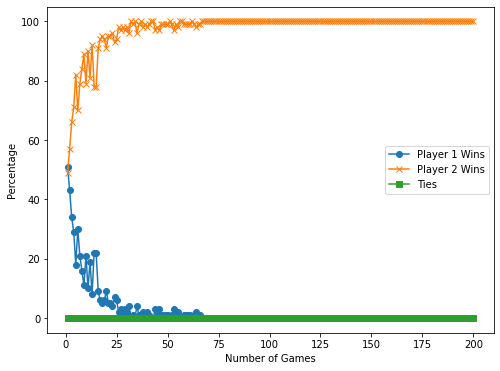

In [16]:
figure(figsize=(8,6))
plot(total_number_of_games,percentage_player1_wins,'-o',label="Player 1 Wins")
plot(total_number_of_games,percentage_player2_wins,'-x',label="Player 2 Wins")
plot(total_number_of_games,percentage_ties,'-s',label="Ties")
xlabel('Number of Games')
ylabel('Percentage')
legend()

In [17]:
Q1_agent.Q

{21: {1: -0.38290013362419023,
  2: 0.056117647863071135,
  3: -0.4397801210681043},
 19: {1: 0, 2: 0.06861039198596922, 3: 0.0},
 13: {1: -0.7659291251247411, 2: -0.7606130881119254, 3: -0.5669993566380974},
 10: {1: 0.7438751427419952, 2: -0.081, 3: -0.149607},
 4: {1: 0, 2: -0.3, 3: 0.9966767069430399},
 17: {1: -0.5974989693295341, 2: -0.2745464088397933, 3: -0.6155729144714769},
 12: {1: 0.20357675216802948, 2: 0, 3: 0.7598434945862657},
 8: {1: 0, 2: 0.0, 3: 0.896183597164811},
 5: {1: -0.9999681371420015, 2: -0.9999680292467438, 3: -0.974746307173873},
 15: {1: 0.0, 2: 0.5537628074481337, 3: 0},
 18: {1: 0.3563135835257753,
  2: -0.018724227827065017,
  3: -0.048019996623406364},
 14: {1: 0.4853327992828509, 2: 0.0, 3: -0.104140566},
 6: {1: 0.8993099925301012, 2: -0.51, 3: -0.3},
 3: {1: -0.51, 2: 0.9999962118130773, 3: -0.3},
 11: {1: -0.1628362105320231, 2: 0.7857862603108758, 3: -0.21100743},
 2: {1: 0.99321776927151, 2: -0.3},
 16: {1: -0.08133218648528331, 2: 0, 3: 0.63503

In [18]:
SaveTable(Q1_agent.Q,"Q1 table.json")
SaveTable(Q2_agent.Q,"Q2 table.json")

In [19]:
def Q2image(Q):
    from numpy import zeros
    im=zeros((22,3))
    for state in range(22):
        if state in Q:
            for action in [1,2,3]:
                if action in Q[state]:
                    im[state,action-1]=Q[state][action]
                    
    return im

In [20]:
from IPython.display import display, clear_output

[Text(0, 1, '1'), Text(1, 1, '2'), Text(2, 1, '3')]

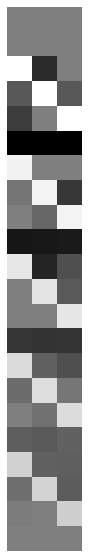

In [22]:
figure(figsize=(4,10))
im=Q2image(Q2_agent.Q)
imshow(im,cmap=cm.gray)
axis('off');
ax=plt.gca()
ax.xaxis.tick_top()
ax.set_yticks(range(22))
ax.set_yticklabels(range(22))
ax.set_xticks([0,1,2])
ax.set_xticklabels([1,2,3])


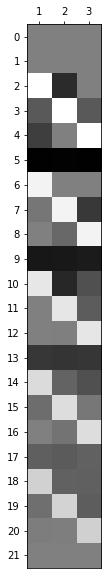

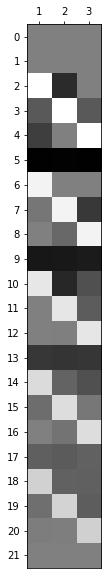

In [24]:
f=figure(figsize=(4,10))
for Q in Qs:
    clear_output(wait=True)
    f.clf()    
    im=Q2image(Q[1])
    imshow(im,vmin=-1,vmax=1,cmap=cm.gray)
    ax=plt.gca()
    ax.xaxis.tick_top()
    ax.set_yticks(range(22))
    ax.set_yticklabels(range(22))
    ax.set_xticks([0,1,2])
    ax.set_xticklabels([1,2,3])
    display(f)
    
